# Live Tennis Probability without Player ID

## Summary
#### In this document I highlight three possible approaches each with unique upsides and downsides. I'll summarize each approach,  present some results, and discuss the outlook of each method. Finally I'll recommend a single method going forward.

## Data Exploration

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time as tm

path = 'C:/Users/u5677455/Dropbox/DataSciencePortfolio/GeniusSports/Data/'
df = pd.read_csv(path+'tennis_match_data.csv')

In [4]:
# Size of the Dataset
df.shape

(610381, 9)

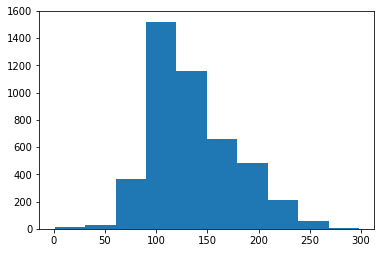

In [5]:
# Rows per fixture
plt.hist(df.groupby(['FixtureId'])['FixtureId'].count())
plt.show()
#The theoretical minimum points required to play is 48, so having any match < 50 is concerning. This might be a medical timeout match.

In [6]:
# Investigating the games that seem too quick
# I used Spyder to open the entire dataframe and found that there is simply data missing for these matches, but there's always a winner reported. No medical timeouts anywhere. With the method I use in this section, each match needs to be complete. I don't spend the time to clean it, and there will be some bugs at the end, but the proof of concept will still work.
df.loc[df.groupby(['FixtureId'])['FixtureId'].transform('count') < 60,:].head()

,FixtureId,Competitor1CurrentGameScorePoints,Competitor1CurrentSetScore,Competitor1MatchScore,Competitor2CurrentGameScorePoints,Competitor2CurrentSetScore,Competitor2MatchScore,Serving,StateOfPlay
4260,3221789,0,0,0,0,0,0,2,PointInProgress
4261,3221789,1,0,0,0,0,0,2,BetweenPoints
4262,3221789,2,0,0,0,0,0,2,BetweenPoints
4263,3221789,3,0,0,0,0,0,2,BetweenPoints
4264,3221789,0,1,0,0,0,0,1,BetweenPoints


In [7]:
#Dropping the matches with fewer than 75 rows
df = df.loc[df.groupby(['FixtureId'])['FixtureId'].transform('count') >= 75,:]
df.shape
#Dropped about 6000 rows

(604438, 9)

In [8]:
# Tabulate the different StateOfPlay values
df.groupby(['StateOfPlay'])['StateOfPlay'].count()
# Looks like suspended play, delays, and medical timeouts are rare
# Medical timeouts are almost certainly informative, but in this approach I won't account for them. The machine learning approaches will account for them and I can investigate there.

StateOfPlay
BetweenPoints                  595278
Challenge                          22
MedicalTimeoutCompetitorOne         2
MedicalTimeoutCompetitorTwo         3
PlaySuspended                      66
PointInProgress                  4635
ShortDelay                         32
WinnerCompetitorOne              2275
WinnerCompetitorTwo              2125
Name: StateOfPlay, dtype: int64

In [9]:
# Does each fixture have a match winner?
df.groupby(['FixtureId'])['FixtureId'].unique().count()

4397

In [10]:
df.StateOfPlay.str.contains('WinnerCompetitor').astype(int).sum()

4400

In [11]:
# Finding fixtures that don't have a match winner or declare more than one
df.loc[:,'winner'] = df.StateOfPlay.str.contains('WinnerCompetitor').astype(int)
df.loc[:,'winner'] = df.groupby(['FixtureId'])['winner'].transform('sum')
len(df.loc[df.groupby(['FixtureId'])['winner'].transform('sum')!=1,:])

604438

In [12]:
# Dropping the fixtures where the winner isn't declared exactly once
df = df.loc[df['winner']==1,:]
df.shape
# Looks like there was only a single match with 97 rows where the same winner was declared 4 times

(604341, 10)

There were a few other strange things that cropped up (like inconsistency in whether tiebreakers were played in the 3rd set or not), but in interest of time, and per instructions to focus on analysis I make due with the data in this state.

## Method 1: Markov Chain
##### The goal here was to obtain a theoretical understanding of the problem to get a sense of the nuances in calculating probability in tennis.

##### This method is based on three papers found here: 
https://pdfs.semanticscholar.org/e870/8ca24b8f67476b3284ec22ccb689dc6229be.pdf  
http://strategicgames.com.au/article2.pdf  
http://strategicgames.com.au/excel.pdf
##### A more succinct introduction to the method: 
https://www.betfair.com.au/hub/news/tennis/tennis-modelling-point-based-models/  
##### Basically using a Markov Chain you can estimate the probability winning even with almost no data at all. The only thing you need to know is the probability of winning a service point and a return point for each player. This can be estimated from tour averages if we can't identify the players. The analysis for this method is much more light than the others because we have data, and I figured using it would be a good idea. In any case I thought I'd show the method for times when data is extremely limited.

#### Here is a quick example table showing the probabilities of winning a game and set using Excel

![image](https://i.imgur.com/Ck0HAuUl.png)

### Evaluation
##### Upsides
•	Transparent  
•	Possible with limited data 
##### Downsides
•	Limited room for improvement from data, what you calculate at the start is what you get
##### Outlook
•	No point in further work as we have the data to get a better model

## Method 2: Data Mining
##### This method was again part of the excercise of understanding the problem, and trying to apply probability in a more theoretical manner where simplifying assumptions are critical. I'm building my own very basic (and extremely over-fitted) classifier in this section.

##### This can be distinguished as a nonparametric direct inference from the data. Basically, I assume all games and sets are iid, and calculate the probability of winning a game of a certain score based on the average game winner across the whole dataset, then I do the same for the set score, then again the same based on match score. I then use a probability tree to find the final chance of player 1 winning based on the current game, set, and match scores.

### Data Prep
##### Create GameId and SetId

In [13]:
df['GameId'] = ((df.Competitor1CurrentGameScorePoints==0) & (df.Competitor2CurrentGameScorePoints==0)).astype(int)
df['GameId'] = df.GameId.cumsum()

df['SetId'] = ((df.Competitor1CurrentGameScorePoints==0) & (df.Competitor2CurrentGameScorePoints==0) &  
              (df.Competitor1CurrentSetScore==0) & (df.Competitor2CurrentSetScore==0)).astype(int)
df['SetId'] = df.SetId.cumsum()

##### Replace high game and set score numbers with adv/deuce equivalents
The reason for this is the probability of winning a game or set ought to only depend on the score diff, not the raw score when above a deuce. This is necessary to avoid tiny sample sizes determining probability at high game and scores.

In [14]:
df['MatchScoreDiff'] = df.Competitor1MatchScore - df.Competitor2MatchScore
df['MatchScoreSum'] = df.Competitor1MatchScore + df.Competitor2MatchScore


# GAMES
df['GameScoreDiff'] = df.Competitor1CurrentGameScorePoints - df.Competitor2CurrentGameScorePoints
df['GameScoreSum'] = df.Competitor1CurrentGameScorePoints + df.Competitor2CurrentGameScorePoints

df['Comp1GameScore'] = df.Competitor1CurrentGameScorePoints
df['Comp2GameScore'] = df.Competitor2CurrentGameScorePoints

# get an indicator for a tiebreaker being played
df['Tiebreaker'] = ((df.MatchScoreSum<2) & (df.Competitor1CurrentSetScore==6) 
        & (df.Competitor2CurrentSetScore==6)).astype(int)

# replace both competitor's scores with 3 if deuce (only for non-tiebreaker games)
df.loc[((df.GameScoreDiff==0)&(df.GameScoreSum>7)&(df.Tiebreaker==0)),('Comp1GameScore','Comp2GameScore')] = 3

# give score of 4 for advantage competitor for non-tiebreaker games
df.loc[((df.GameScoreDiff==1)&(df.GameScoreSum>7)&(df.Tiebreaker==0)),'Comp1GameScore'] = 4
df.loc[((df.GameScoreDiff==1)&(df.GameScoreSum>7)&(df.Tiebreaker==0)),'Comp2GameScore'] = 3

df.loc[((df.GameScoreDiff==-1)&(df.GameScoreSum>7)&(df.Tiebreaker==0)),'Comp2GameScore'] = 4
df.loc[((df.GameScoreDiff==-1)&(df.GameScoreSum>7)&(df.Tiebreaker==0)),'Comp1GameScore'] = 3

# now repeat a similar process for tiebreaker games
df.loc[((df.GameScoreDiff==0)&(df.GameScoreSum>13)&(df.Tiebreaker==1)),('Comp1GameScore','Comp2GameScore')] = 6

df.loc[((df.GameScoreDiff==1)&(df.GameScoreSum>13)&(df.Tiebreaker==1)),'Comp1GameScore'] = 7
df.loc[((df.GameScoreDiff==1)&(df.GameScoreSum>13)&(df.Tiebreaker==1)),'Comp2GameScore'] = 6

df.loc[((df.GameScoreDiff==-1)&(df.GameScoreSum>13)&(df.Tiebreaker==1)),'Comp2GameScore'] = 7
df.loc[((df.GameScoreDiff==-1)&(df.GameScoreSum>13)&(df.Tiebreaker==1)),'Comp1GameScore'] = 6


# SETS
df['SetScoreDiff'] = df.Competitor1CurrentSetScore - df.Competitor2CurrentSetScore
df['SetScoreSum'] = df.Competitor1CurrentSetScore + df.Competitor2CurrentSetScore

df['Comp1SetScore'] = df.Competitor1CurrentSetScore
df['Comp2SetScore'] = df.Competitor2CurrentSetScore

# replace both competitor's scores with 6 if 3rd set and tied
df.loc[((df.SetScoreDiff==0)&(df.SetScoreSum>13)),('Comp1SetScore','Comp2SetScore')] = 6

# give score of 7 for advantage competitor for final sets
df.loc[((df.SetScoreDiff==1)&(df.SetScoreSum>13)),'Comp1SetScore'] = 7
df.loc[((df.SetScoreDiff==1)&(df.SetScoreSum>13)),'Comp2SetScore'] = 6

df.loc[((df.SetScoreDiff==-1)&(df.SetScoreSum>13)),'Comp2SetScore'] = 7
df.loc[((df.SetScoreDiff==-1)&(df.SetScoreSum>13)),'Comp1SetScore'] = 6


##### Get variables with the eventual match, set, and game winner

In [15]:
# Match
df['winMatch1'] = (df['StateOfPlay']=='WinnerCompetitorOne').astype(int)
df['comp1WinsMatch'] = df.groupby(['FixtureId'])['winMatch1'].transform('max')

# Set (this is messing up somehow and giving me some wrong set probabilities)
df['winSet1'] = ((df.SetId.shift(-1) - df.SetId == 1) & 
                (df.SetScoreDiff>0)).astype(int)
df['comp1WinsSet'] = df.groupby(['SetId'])['winSet1'].transform('max')

# Game
df['winGame1'] = ((df.GameId.shift(-1) - df.GameId == 1) & 
                (df.GameScoreDiff>0)).astype(int)
df['comp1WinsGame'] = df.groupby(['GameId'])['winGame1'].transform('max')

##### Now I create sets of probabilities for game, set, and match depending on the score

In [16]:
# Match
dfMatchProbs = df.groupby(['Competitor1MatchScore','Competitor2MatchScore'])['comp1WinsMatch'].mean()

# Set
dfSetProbs = df.groupby(['Serving','Comp1SetScore','Comp2SetScore'])['comp1WinsSet'].mean()

# There are some anomalies where a tiebreaker is played in the 3rd set of the
# match for some reason. We can see some of them using this command
#df.loc[(df.Tiebreaker==0)&(df.Comp1GameScore + df.Comp2GameScore>7)]

# Game
dfGameProbs = df.groupby(['Tiebreaker','Serving','Comp1GameScore','Comp2GameScore'])['comp1WinsGame'].mean()

# This shows what I'm doing here, each combination shows the probability of Competitor 1 winning
#dfMatchProbs
dfGameProbs

Tiebreaker  Serving  Comp1GameScore  Comp2GameScore
0           1        0               0                 0.707828
                                     1                 0.526262
                                     2                 0.304888
                                     3                 0.107032
                                     4                 0.010811
                                     5                 0.000000
                                     6                 0.000000
                     1               0                 0.825930
                                     1                 0.679793
                                     2                 0.457541
                                     3                 0.198802
                                     4                 0.014925
                                     5                 0.000000
                                     6                 0.000000
                                     7              

##### Here I'll showcase how a score input is transformed into a final win probability
G (Tiebreaker, Serving, Competitor1GameScore, Competitor2GameScore) = Probability of Competitor 1 Winning the Game

S (Serving, Competitor1SetScore, Competitor2SetScore) = Probability of Competitor 1 Winning the Set

M (Competitor1MatchScore, Competitor2MatchScore) = Probability of Competitor 1 Winning the Match

##### Current Score   
Game: 4 - 3, Set: 2 - 4, Match: 1 - 0

![Image](https://i.imgur.com/gOnR3GWl.png)

In [17]:
# take any point in the game and calculate the prob that p1 wins match
def getProb(serving, p1g, p2g, p1s, p2s, p1m, p2m, tiebreaker,quiet):
    
    nextServe = 3 - serving

    gameProb = dfGameProbs[(tiebreaker,serving,p1g,p2g)]
    
    # this takes care of a small bug that occurs from high set scores
    try:
        setProbW = dfSetProbs[(nextServe,(p1s+1),p2s)]
        setProbL = dfSetProbs[(nextServe,p1s,(p2s+1))]
    except:
        setProbW = dfSetProbs[(nextServe,p1s,(p2s-1))]
        setProbL = dfSetProbs[(nextServe,(p1s-1),p2s)]       
    
    matchProbWW = dfMatchProbs[((p1m+1),p2m)]
    matchProbWL = dfMatchProbs[(p1m,(p2m+1))]
    matchProbLW = dfMatchProbs[((p1m+1),p2m)]
    matchProbLL = dfMatchProbs[(p1m,(p2m+1))]
    
    #win game, win set, win match
    branch1 = gameProb*setProbW*matchProbWW
    #win game, lose set, win match
    branch2 = gameProb*(1-setProbW)*matchProbWL
    #lose game, win set, win match
    branch3 = (1-gameProb)*setProbL*matchProbLW
    #lose game, lose set, win match
    branch4 = (1-gameProb)*(1-setProbL)*matchProbLL
    
    matchProb = branch1 + branch2 + branch3 + branch4
    
    #probability of winning the set
    setProb = gameProb*setProbW + (1-gameProb)*setProbL
    if quiet==False:
        print('Serving: Player ' + str(serving) +
              '\nGame Score: ' + str(p1g) + '-' + str(p2g) + 
              '\nSet Score: ' + str(p1s) + '-' + str(p2s) +  
              '\nMatch Score: ' + str(p1m) + '-' + str(p2m))
        print('Probability of winning the game: ' + str(gameProb) + 
              '\nProbability of winning the set: ' + str(setProb) + 
              '\nProbability of winning the match: ' + (str(matchProb)))
    
    return [gameProb,setProb,matchProb]

In [18]:
getProb(1,4,3,2,4,1,0,0,False)

Serving: Player 1
Game Score: 4-3
Set Score: 2-4
Match Score: 1-0
Probability of winning the game: 0.852485807672
Probability of winning the set: 0.124145572009
Probability of winning the match: 0.583261867357


[0.8524858076724583, 0.1241455720092187, 0.58326186735723784]

In [19]:
#A function that will print out live probabilities as points are played
def playGame(i,time,quiet):
    ID = df.FixtureId[i]
    plotting = pd.DataFrame(columns=['matchProb'],index=np.arange(0))
    while df.loc[i,'FixtureId']==ID:
        
        serving = df.Serving[i]
        p1g = df.Comp1GameScore[i]
        p2g = df.Comp2GameScore[i]
        p1s = df.Comp1SetScore[i]
        p2s = df.Comp2SetScore[i]
        p1m = df.Competitor1MatchScore[i]
        p2m = df.Competitor2MatchScore[i]
        tiebreaker = df.Tiebreaker[i]
        try:
            probs = getProb(serving, p1g, p2g, p1s, p2s, p1m, p2m, tiebreaker,quiet)
            plotting.loc[(i),'matchProb'] = probs[2]
        except:
            if quiet==False:
                print('error')
                print('Serving: Player ' + str(serving) +
                  '\nGame Score: ' + str(p1g) + '-' + str(p2g) + 
                  '\nSet Score: ' + str(p1s) + '-' + str(p2s) +  
                  '\nMatch Score: ' + str(p1m) + '-' + str(p2m) +
                  '\nTiebreaker: ' + str(tiebreaker))
                plotting.loc[(i),'matchProb'] = plotting.loc[((i)-1),'matchProb']
        if quiet==False:
            print('row ' + str(i) + '\n')
        tm.sleep(time)
        i += 1
    return plotting

In [20]:
# Going through a game I picked randomly
plotting = playGame(0,0,True)   

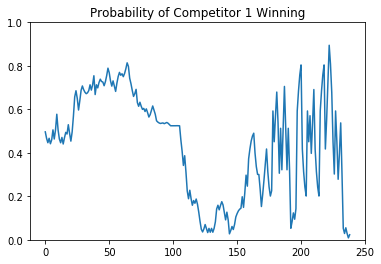

In [24]:
plt.plot(plotting.index,plotting)
plt.axis(ymin=0,ymax=1)
plt.title('Probability of Competitor 1 Winning')
plt.show()

### Evaluation
##### Upsides
•	With a lot of data, could get really accurate  
•	Runs really fast  
•	Non parametric, so feature distributions don’t matter as much
##### Downsides
•	Sort of like a stupidly over-fitted ML model  
•	A bit buggy – lots of time and care to code  
•	Have to limit feature set, taking additional features will hurt accuracy
##### Outlook
•	Fun exercise but validating and improving beyond a basic Machine Learning model is probably going to be quite time consuming

## Method 3: Machine Learning Approach
##### Here I use a few simple sklearn packages to fit a model and test the accuracy of the predictions. I don't make any direct comparisions with Approach 1 in terms of accuracy for two reasons: 1) The Data Mining approach is a little like forcing a perfect over-fit model so accuracy will be high there but not generalizable, 2) The Data Mining approach still contains some bugs that cause a few prediction cells missing for matches with certain characteristics.
##### Due to time, data, and hardware constraints I only do exploratory analysis. I'm also not cleaning the data because each row is treated as independent (and shuffled for training) in these methods. Sequence doesn't matter in the slightest here so having small, incomplete snapshots of matches is still valuable information for these classifiers.

In [146]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

path = 'C:/Users/u5677455/Dropbox/DataSciencePortfolio/GeniusSports/Data/'

df = pd.read_csv(path+'tennis_match_data.csv')

##### Create binary variables for StateOfPlay values, and create a variable for who eventually wins the match

In [147]:
for x in df.StateOfPlay.unique():
    df[(x)] = (df.StateOfPlay==(x)).astype(int)
    
df['win1'] = (df['StateOfPlay']=='WinnerCompetitorOne').astype(int)
df['win1'] = df.groupby(['FixtureId'])['win1'].transform('max')

In [148]:
#Create X and y, then split into training and test samples
#I'd normally include a cross-validation but here I'm just using GridSearch for parameter optimization which automatically splits the training sample to validate
X = df.loc[:,('Competitor1CurrentGameScorePoints',
       'Competitor1CurrentSetScore', 'Competitor1MatchScore',
       'Competitor2CurrentGameScorePoints', 'Competitor2CurrentSetScore',
       'Competitor2MatchScore', 'Serving', 'PointInProgress',
       'BetweenPoints', 'WinnerCompetitorTwo', 'WinnerCompetitorOne',
       'ShortDelay', 'PlaySuspended', 'Challenge',
       'MedicalTimeoutCompetitorTwo', 'MedicalTimeoutCompetitorOne')]
y = df.loc[:,'win1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

##### Limited to Random Forests, Extra Trees, and Neural Network because they obtained the highest accuracy

In [149]:
#Random Forests
#Pretty quick
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
print('Random Forest Accuracy: ' + str(clf.score(X_test, y_test)))
RF1_Prob = (clf.predict_proba(X_test))[:,1]
print('Random Forests 1 MSE: ' + str(round(mean_squared_error(y_test,RF1_Prob),3)))

#Extra Trees
#Pretty quick
clf = ExtraTreesClassifier()
clf.fit(X_train,y_train)
print('Extra Trees Accuracy: ' + str(clf.score(X_test, y_test)))
ET1_Prob = clf.predict_proba(X_test)[:,1]
print('Extra Trees 1 MSE: ' + str(round(mean_squared_error(y_test,ET1_Prob),3)))

#Neural Net
#Slower but a bit more accurate
clf = MLPClassifier()
clf.fit(X_train,y_train)
print('Neural Net Accuracy: ' + str(clf.score(X_test, y_test)))
NN1_Prob = clf.predict_proba(X_test)[:,1]
print('Neural Net 1 MSE: ' + str(round(mean_squared_error(y_test,NN1_Prob),3)))

Random Forest Accuracy: 0.738989159818
Random Forests 1 MSE: 0.17
Extra Trees Accuracy: 0.738890860934
Extra Trees 1 MSE: 0.17
Neural Net Accuracy: 0.742795511018
Neural Net 1 MSE: 0.167


In [150]:
#Check if doing an average MSE system improves accuracy
Vote1MSE = ((RF1_Prob+ET1_Prob+NN1_Prob)/3) #this is worse than just ET2 again
print('MSE Voting Error: ' + str(round(mean_squared_error(y_test,Vote1MSE),3))) #actually does worse

MSE Voting Error: 0.168


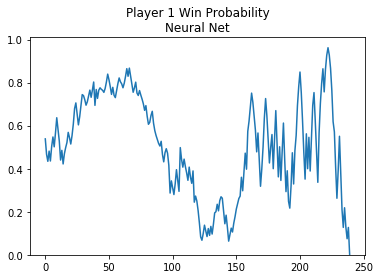

In [152]:
df['PlotPredict'] = clf.predict_proba(X)[:,1]

plt.plot(df.loc[0:239,'PlotPredict'])
plt.axis(ymin=0,ymsax=1)
plt.title('Player 1 Win Probability\nNeural Net')
plt.show()

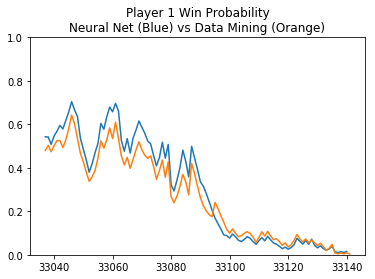

In [83]:
df['PlotPredict'] = clf.predict_proba(X)[:,1]

plt.plot(df.loc[33037:33141,'PlotPredict'])
plt.plot(plotting.index,plotting)
plt.axis(ymin=0,ymax=1)
plt.title('Player 1 Win Probability\nNeural Net (Blue) vs Data Mining (Orange)')
plt.show()

##### Wondered if time spent on feature engineering would yield better results.

In [90]:
#Points won up to that point in the match - something like a point differential
df['c2point'] = ((df.Competitor2CurrentGameScorePoints.shift(-1) - df.Competitor2CurrentGameScorePoints == 1)).astype(int)
df['c1point'] = ((df.Competitor1CurrentGameScorePoints.shift(-1) - df.Competitor1CurrentGameScorePoints == 1)).astype(int)

df['c2PointsWon'] = df.groupby('FixtureId')['c2point'].cumsum()
df['c1PointsWon'] = df.groupby('FixtureId')['c1point'].cumsum()
df['pointRatio'] = (df.c2PointsWon+1)/(df.c1PointsWon+1)
#df['pointRatio'] = (df.c2PointsWon-df.c1PointsWon)

In [91]:
X = df.loc[:,('Competitor1CurrentGameScorePoints',
       'Competitor1CurrentSetScore', 'Competitor1MatchScore',
       'Competitor2CurrentGameScorePoints', 'Competitor2CurrentSetScore',
       'Competitor2MatchScore', 'Serving', 'PointInProgress',
       'BetweenPoints', 'WinnerCompetitorTwo', 'WinnerCompetitorOne',
       'ShortDelay', 'PlaySuspended', 'Challenge',
       'MedicalTimeoutCompetitorTwo', 'MedicalTimeoutCompetitorOne','pointRatio')]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [113]:
#Neural Net
#A small increase in accuracy from the extra information
clf = MLPClassifier()
clf.fit(X_train,y_train)
print('Neural Net Accuracy: ' + str(clf.score(X_test, y_test)))
NN1_Prob = clf.predict_proba(X_test)[:,1]
print('Neural Net 1 MSE: ' + str(round(mean_squared_error(y_test,NN1_Prob),3)))

Neural Net Accuracy: 0.744952625399
Neural Net 1 MSE: 0.166


Overall, doesn't appear that feature engineering in this manner is likely to bear fruit. However, with GPU support it's possible to add variables containing the sequence of points which would give the algorithm close to the maximum amount of information from this data possible. It would add at least 250 new features.  
##### GridSearch Parameter Tuning

In [114]:
rf = RandomForestClassifier()
rf_params = {'n_estimators': [100,150,200], 
             'max_features': [3,5,7], 
             'max_depth': [10,15,20]}

grid_rf = GridSearchCV(rf, param_grid = rf_params, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
RFGrid_Prob = grid_rf.predict_proba(X_test)[:,1]
print(grid_rf.best_params_)
print('Random Forest Grid Search MSE: ' + str(round(mean_squared_error(y_test,RFGrid_Prob),3)))

{'max_depth': 15, 'max_features': 5, 'n_estimators': 200}
Random Forest Grid Search MSE: 0.165


In [94]:
et = ExtraTreesClassifier()
et_params = {'n_estimators': [100,150,200], 
             'max_features': [3,5,7], 
             'max_depth': [10,15,20]}

grid_et = GridSearchCV(et, param_grid = et_params, scoring='roc_auc')
grid_et.fit(X_train, y_train)
ETGrid_Prob = grid_et.predict_proba(X_test)[:,1]
print(grid_et.best_params_)
print('Extra Trees 2 Grid Search MSE: ' + str(round(mean_squared_error(y_test,ETGrid_Prob),3)))

{'max_depth': 15, 'max_features': 7, 'n_estimators': 200}
Extra Trees 2 Grid Search MSE: 0.165


In [99]:
nn = MLPClassifier()
nn_params = {'hidden_layer_sizes': [(100,100,100,100,100,100,100),
             (500),(500,500,500,500,500),(1000)],
             'alpha': [.00003,.0001,.0003],
             'learning_rate': ['constant'],
             'learning_rate_init': [.0003,.001,.003],
             'early_stopping': [True]}

grid_nn = GridSearchCV(nn, param_grid = nn_params, scoring='roc_auc')
grid_nn.fit(X_train, y_train)
NNGrid_Prob = grid_nn.predict_proba(X_test)[:,1]
print(grid_nn.best_params_)
print('Neural Net Grid Search MSE: ' + str(round(mean_squared_error(y_test,NNGrid_Prob),3)))

{'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100, 100, 100, 100, 100, 100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
Neural Net Grid Search MSE: 0.165


In [107]:
NNGrid_Prob = grid_nn.predict_proba(X)[:,1]
ETGrid_Prob = grid_et.predict_proba(X)[:,1]
RFGrid_Prob = grid_rf.predict_proba(X)[:,1]

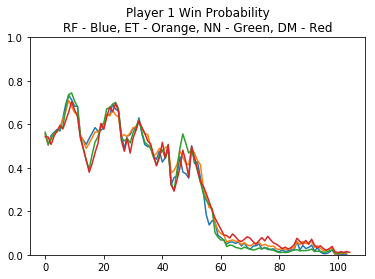

In [112]:
plt.plot(RFGrid_Prob[33037:33141])
plt.plot(ETGrid_Prob[33037:33141])
plt.plot(NNGrid_Prob[33037:33141])
plt.plot(np.array(df.loc[33037:33141,'PlotPredict']))
plt.axis(ymin=0,ymax=1)
plt.title('Player 1 Win Probability\nRF - Blue, ET - Orange, NN - Green, DM - Red')
plt.show()

### Evaluation
##### Upsides
•	With GPU support could add point sequence and scores from games leading up to get the most detailed picture possible  
•	With player-specific data this could get incredibly accurate  
•	Easy to validate  
•	Complete (will provide estimates for any combination of inputs)  
•	Neural Nets can infer feature distributions from the data
##### Downsides
•	Computationally intensive  
•	Least transparent (especially Neural Nets)  
•	Random Forests prone to overfitting, and can't generalize past current data
##### Outlook
•	With more data and better hardware this approach can probably get extremely accurate with comparatively little explicit coding.

## Final Recommendation

#### If additional time were allotted to this task, I'd recommend pursuing the Neural Network, trying variations (CNN, RNN, etc), and adding sequential features.